# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [2]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from addict import Dict as Adict

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import VAMPNet, vampnet_loss, VAMPNetModel
import mdshare

## Functions

In [36]:
class CelerityVAMPNet(nn.Module):
    DEFAULT = Adict(
        lag_time = 1, 
        network_dimensions = [], 
        lr = 5e-4, 
        n_epochs = 30, 
        optimizer=torch.optim.Adam, 
        score = Adict(
              method='VAMP2', 
              mode='regularize', 
              epsilon=1e-6
        ), 
        loss = vampnet_loss, 
        device="cpu"
    ) 
    def __init__(self, options): 
        super(CelerityVAMPNet, self).__init__()
        self.options = self.get_options(options)

        self.t_0 = self.create_lobe()
        self.t_tau = self.t_0 
        self.optimizer = self.options.optimizer(self.parameters(), lr=self.options.lr)
        self.device = torch.device(self.options.device)
        self.to(self.device)
        
        self.step = 0
        self.dict_scores = dict({
            "train": {self.options.score.method: {}, "loss": {}},
            "validate": {self.options.score.method: {}, "loss": {}},
            })

    def create_lobe(self): 
        dims = self.options.network_dimensions
        input_dim = dims[0]
        output_dim = dims[-1]
        lobe = nn.Sequential(nn.BatchNorm1d(input_dim))
        for i in range(1,len(dims)-1):
            in_dim = dims[i-1]
            out_dim = dims[i]
            lobe.append(nn.Linear(in_dim, out_dim))
            lobe.append(nn.ELU()) 
        lobe.append(nn.Linear(out_dim, output_dim))
        lobe.append(nn.Softmax(dim=1))
        return lobe



    @classmethod
    def get_options(cls, options=None):
        if options is None:
            options = {}
        combined_options = Adict(cls.get_default_options())
        combined_options.update(Adict(options))
        # combined_options.version = __version__
        combined_options.feature = cls.__name__
        return combined_options

    @classmethod
    def get_default_options(cls):
        return Adict(cls.DEFAULT)

    def forward(self, x):
        x_0 = self.t_0(x[0])
        x_t = self.t_tau(x[1])
        return (x_0, x_t)


    def fit(self, train_loader, validate_loader): 
        self.optimizer.zero_grad()
        for epoch_ix in range(self.options.n_epochs): 
            self.train()
            for batch in train_loader: 
                self.train_batch(batch)

            self.eval()
            if validate_loader is not None: 
                self.validate(validate_loader)

    def score_batch(self, x):
        x0, xt = x[0].to(self.device), x[1].to(self.device)
        output = self((x0, xt)) # calls the forward method
        loss = self.options.loss(output[0], output[1], **self.options.score)
        return loss

    def train_batch(self,x): 
        self.optimizer.zero_grad()
        loss = self.score_batch(x)
        loss.backward()
        self.optimizer.step()
        loss_value = loss.item()
        self.dict_scores['train'][self.options.score.method][self.step] = -loss_value
        self.dict_scores['train']['loss'][self.step] = loss_value
        self.step +=1 

    def validate(self, data_loader): 
        losses = []
        for i, batch in enumerate(data_loader):
            with torch.no_grad():
                val_loss = self.score_batch(batch)
                losses.append(val_loss)
            mean_score = -torch.mean(torch.stack(losses)).item()   

        self.dict_scores['validate'][self.options.score.method][self.step] = mean_score
        self.dict_scores['validate']['loss'][self.step] = -mean_score

# # Setup model
# device = torch.device("cuda")
# model = CelerityVAMPNet(input_dim=config.input_dim, output_dim=config.output_dim, stationary=True)
# model = model.to(device)

# Optimizer
# optimizer = config.optimizer(model.parameters(), lr=config.lr)

# create data loaders


# # accumulators
# init_step = 0
# train_scores = []
# valid_scores = []

# # fit
# for epoch in range(config.n_epochs):
#     print(epoch, end=', ')
#     train_scores.extend(train_epoch(device, model, optimizer, loader_train, config, init_step))
#     init_step = train_scores[-1][0]

#     valid_scores.extend(validate(device, model, loader_val, config, init_step))

# train_scores = np.array(train_scores)
# valid_scores = np.array(valid_scores)
#     for batch_t_0, batch_t_tau in loader_train: 
#         # Set lobes to train mode (we use batch normalization)
#         ct_lobes[0].train()
#         ct_lobes[1].train()

#         # calculate loss
#         optimizer.zero_grad()
#         x_0 = ct_lobes[0](batch_t_0.to(device=device))
#         x_t = ct_lobes[1](batch_t_tau.to(device=device))
#         loss = vampnet_loss(x_0, x_t, method=config.score_method, 
#                             epsilon=config.score_eps, mode=config.score_mode)
#         step += 1
#         train_scores.append([step, (-loss).item()])

#         # update parameters
#         loss.backward()
#         optimizer.step()
        
#     # validate
#     scores = []
#     for i, (vbatch_t_0, vbatch_t_tau) in enumerate(loader_val):
#         ct_lobes[0].eval()
#         ct_lobes[1].eval()
#         with torch.no_grad():
#             val_0 = ct_lobes[0](vbatch_t_0.to(device=device))
#             val_t = ct_lobes[1](vbatch_t_tau.to(device=device))
#             val_loss = vampnet_loss(val_0,val_t, method=config.score_method, 
#                         epsilon=config.score_eps, mode=config.score_mode)
#             scores.append(val_loss)
#         mean_score = torch.mean(torch.stack(scores)).item()
#     valid_scores.append([step, mean_score])

## Get GPU

In [19]:
assert torch.cuda.is_available(), "Need a GPU with CUDA" 
torch.backends.cudnn.benchmark = True

## Paths

In [20]:
data_dir = "data"
coordinates_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')

mdshare.fetch(coordinates_path.name, working_directory=data_dir)

'data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz'

## Load data

In [21]:
with np.load(coordinates_path.open('rb')) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]


## Configuration

In [33]:
config = Adict(
        lag_time = 1, 
        network_dimensions = [30, 100, 100, 6], 
        lr = 5e-4, 
        n_epochs = 5, 
        optimizer=torch.optim.Adam, 
        score = Adict(
              method='VAMP2', 
              mode='regularize', 
              epsilon=1e-6
        ), 
        loss = vampnet_loss, 
        device="cuda"
    ) 
lag_time = 1
validation_split = 0.3

In [34]:
dataset = to_dataset(data=data, lagtime=lag_time)
n_val = int(len(dataset)*validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 

## Celerity model


In [37]:
mod = CelerityVAMPNet(config)
mod.fit(loader_train, loader_val)

In [38]:
mod.dict_scores

{'train': {'VAMP2': {0: 2.490115165710449,
   1: 2.743927001953125,
   2: 2.9087395668029785,
   3: 3.0126490592956543,
   4: 3.1080095767974854,
   5: 3.144951105117798,
   6: 3.174180030822754,
   7: 3.200963020324707,
   8: 3.2705233097076416,
   9: 3.283376455307007,
   10: 3.3368470668792725,
   11: 3.3472063541412354,
   12: 3.3973913192749023,
   13: 3.428586483001709,
   14: 3.424947738647461,
   15: 3.4686615467071533,
   16: 3.4678964614868164,
   17: 3.4672672748565674,
   18: 3.5156877040863037,
   19: 3.4927611351013184,
   20: 3.5358245372772217,
   21: 3.52846622467041,
   22: 3.5712270736694336,
   23: 3.5740654468536377,
   24: 3.536184549331665,
   25: 3.5739805698394775,
   26: 3.5740725994110107,
   27: 3.6348021030426025,
   28: 3.6237668991088867,
   29: 3.6110994815826416,
   30: 3.585996627807617,
   31: 3.585629940032959,
   32: 3.6211936473846436,
   33: 3.606419801712036,
   34: 3.638981819152832,
   35: 3.6133406162261963,
   36: 3.61100435256958,
   37: 3.6

# Deeptime vs Celerity

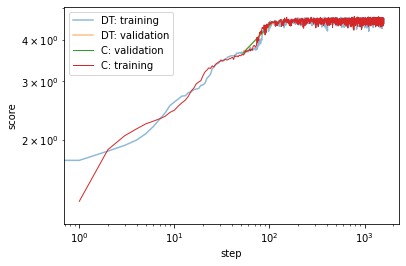

In [56]:
plt.loglog(*dt_est.train_scores.T, label='DT: training', alpha=0.5)
plt.loglog(*dt_est.validation_scores.T, label='DT: validation', alpha=0.5)
plt.plot(valid_scores[:, 0], valid_scores[:, 1], label='C: validation',lw=1)
plt.plot(train_scores[:, 0], train_scores[:, 1], label='C: training',lw=1)
plt.xlabel('step')
plt.ylabel('score')
plt.xscale('log')
plt.legend();



In [57]:
ct_mod = VAMPNetModel(model.t_0, model.t_tau, device=device)
ct_its = its(ct_mod, config)
dt_its = its(dt_mod, config)

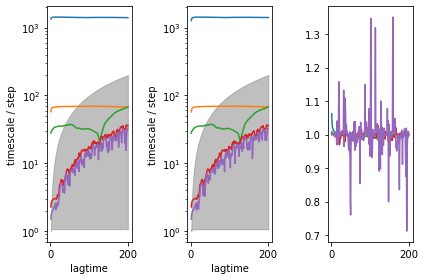

In [58]:
f, axes = plt.subplots(1, 3)
itss = [dt_its, ct_its]
for i in range(2):
    ax = axes[i]
    its = itss[i]
    ax.semilogy(its[0], its[1])
    ax.set_xlabel('lagtime')
    ax.set_ylabel('timescale / step')
    ax.fill_between(its[0], ax.get_ylim()[0]*np.ones(len(its[1])), its[0], alpha=0.5, color='grey')

axes[-1].plot(itss[0][0], np.array(itss[0][1])/np.array(itss[1][1]))
axes[-1].set_ylim()
plt.tight_layout()